In [27]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.mobilenet import MobileNet

In [28]:
SOURCE_IMAGES = "CheXpert-v1.0-small\\train"
print(os.path.join(SOURCE_IMAGES, "*.jpg"))
images = glob(os.path.join(SOURCE_IMAGES,"pa*","st*", "*.jpg"))
print(len(images))


CheXpert-v1.0-small\train\*.jpg
223414


In [29]:
labels = pd.read_csv('train2.csv')
labels.head(2)

,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


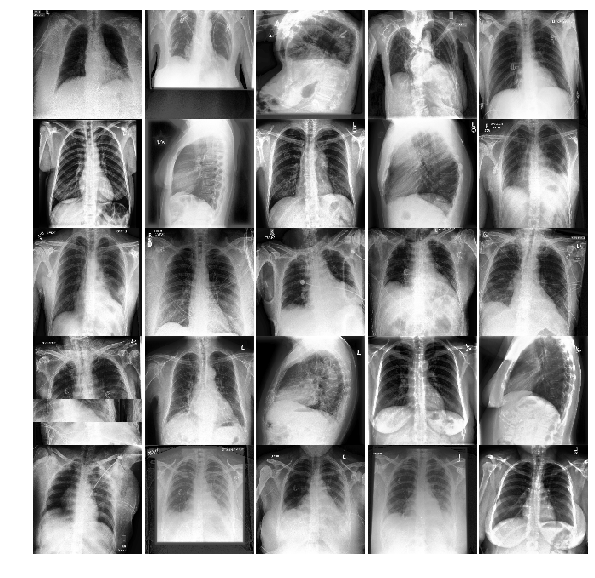

In [4]:
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in images[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

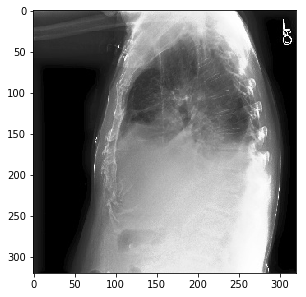

In [5]:
r = random.sample(images, 1)
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.imshow(cv2.imread(r[0]))

In [36]:
imageid = (labels.iloc[:1000])
CorelatedDiseases1 = ['Path','Lung Opacity','Edema']
CorelatedDiseases2 = ['Path','Lung Opacity','Consolidation','Pneumonia']
CorelatedDiseases3 = ['Lung Opacity','Lung Lesion']
CorelatedDiseases4 = ['Enlarged Cardiomediastinum','Cardiomegaly']
CorelatedDiseases5 = ['Lung Opacity','Atelectasis']
CorelatedDiseases6 = ['Lung Opacity','Pneumonia']
CorelatedDiseases7 = ['No Finding']
CorelatedDiseases8 = ['Support Devices']
CorelatedDiseases9 = ['Fracture']
CorelatedDiseases10 = ['Pneumothorax','Pleural Effusion','Pleural Other']
print(CorelatedDiseases1)
imageid = imageid[CorelatedDiseases1]
imageid['Path'] = imageid['Path'].str.replace('/','')


['Path', 'Lung Opacity', 'Edema']


In [42]:



def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    
    x = [] # images as arrays
    y = [] # labels
    WIDTH = 221
    HEIGHT = 221
    for img in images[:900]:
        # Read and resize image
        imid = img.replace('\\','')
        mylabel = int(imageid.loc[imageid['Path']== imid]['Lung Opacity'].values)
        mylabel1 =int(imageid.loc[imageid['Path']== imid]['Edema'].values)
        mylabel = (mylabel*1)+(mylabel1*2)
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        y.append(mylabel)
       
    return x,y


In [43]:
X,y = proc_images()
df = pd.DataFrame()
df["images"]=X
df["labels"]=y
print(len(df), df.images[0].shape)
df.head()

900 (221, 221, 3)


,images,labels
0,"[[[0, 0, 0], [53, 53, 53], [50, 50, 50], [49, ...",0
1,"[[[14, 14, 14], [21, 21, 21], [20, 20, 20], [2...",1
2,"[[[209, 209, 209], [180, 180, 180], [166, 166,...",1
3,"[[[19, 19, 19], [20, 20, 20], [17, 17, 17], [1...",1
4,"[[[2, 2, 2], [1, 1, 1], [4, 4, 4], [1, 1, 1], ...",2


In [9]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Representative Image')
    b = cv2.resize(a, (512,512))
    plt.imshow(b)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

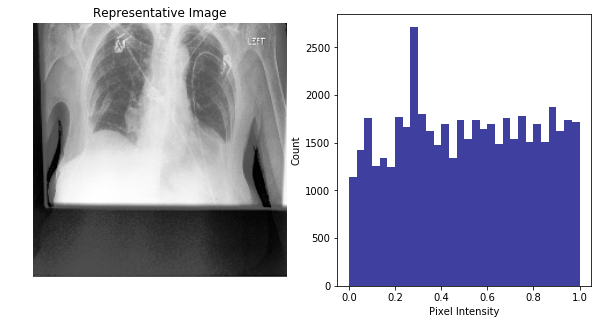

In [45]:
X=np.array(X)
X=X/255.0
plotHistogram(X[1])

In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
# Reduce Sample Size for DeBugging
print(X_train.shape, X_test.shape)
X_train = X_train[0:720] 
Y_train = np.array(Y_train[0:720])
X_test = X_test[0:180] 
Y_test = np.array(Y_test[0:180])

(720, 221, 221, 3) (180, 221, 221, 3)


In [50]:
print("Training Data Shape:", Y_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Training Data Shape:", len(X_train), X_train[0].shape)
print("Testing Data Shape:", len(X_test), X_test[0].shape)

Training Data Shape: (720,)
Testing Data Shape: (180, 221, 221, 3)
Training Data Shape: 720 (221, 221, 3)
Testing Data Shape: 180 (221, 221, 3)


In [51]:
Y_trainHot = to_categorical(Y_train)
Y_testHot = to_categorical(Y_test)


In [52]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(y), y)
print(class_weight)

[0.53699284 0.78671329 2.5        2.14285714]


In [53]:
dict_characters = {0: 'No_Finding', 1: 'Lung_Opacity_Without_Edema', 
        2: 'No_Lung_Opacity_With_Edema', 3:'Lung_Opacity_With_Edema'}

In [16]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [17]:
def runCNNconfusion(a,b,c,d,e,f,g,h):
    # In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
    batch_size = 128
    num_classes = f
    epochs = g
    #img_rows, img_cols = X_train.shape[1],b.shape[2]
    input_shape = (128, 128, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape,strides=h))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(1024, activation = "relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    # Define the optimizer
    optimizer = Adagrad()
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.4,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.4,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    datagen.fit(a)
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, class_weight = e,  validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0) 
    plot_learning_curve(history)
    plt.show()
    plotKerasLearningCurve()
    plt.show()
    print('\nKeras CNN #2B - accuracy:', score[1],'\n')
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1), target_names=list(dict_characters.values())), sep='')    
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values()))
    plt.show()

Epoch 1/6
3/2 [====================================] - 24s 8s/step - loss: 5.1733 - acc: 0.4531 - val_loss: 15.3122 - val_acc: 0.0500
Epoch 2/6
3/2 [====================================] - 20s 7s/step - loss: 9.2716 - acc: 0.4156 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 3/6
3/2 [====================================] - 19s 6s/step - loss: 7.6315 - acc: 0.5109 - val_loss: 10.8796 - val_acc: 0.2500
Epoch 4/6
3/2 [====================================] - 20s 7s/step - loss: 8.5921 - acc: 0.4594 - val_loss: 10.4768 - val_acc: 0.3500
Epoch 5/6
3/2 [====================================] - 20s 7s/step - loss: 8.5443 - acc: 0.4484 - val_loss: 12.7066 - val_acc: 0.1500
Epoch 6/6
3/2 [====================================] - 20s 7s/step - loss: 8.7724 - acc: 0.4484 - val_loss: 11.2827 - val_acc: 0.3000


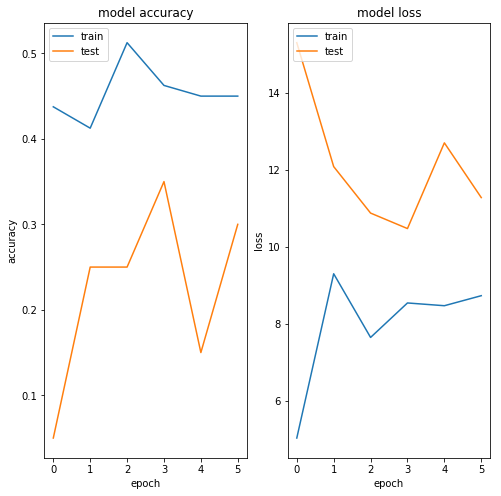

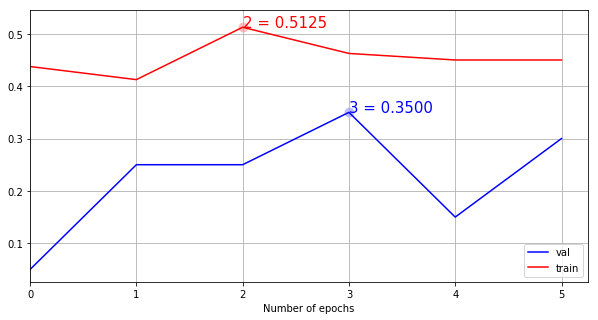


Keras CNN #2B - accuracy: 0.30000001192092896 



D:\Projects\An3\envs\naveen\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Projects\An3\envs\naveen\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Projects\An3\envs\naveen\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                            precision    recall  f1-score   support

                No_Finding       0.00      0.00      0.00        12
Lung_Opacity_Without_Edema       0.30      1.00      0.46         6
No_Lung_Opacity_With_Edema       0.00      0.00      0.00         1
   Lung_Opacity_With_Edema       0.00      0.00      0.00         1

                 micro avg       0.30      0.30      0.30        20
                 macro avg       0.07      0.25      0.12        20
              weighted avg       0.09      0.30      0.14        20



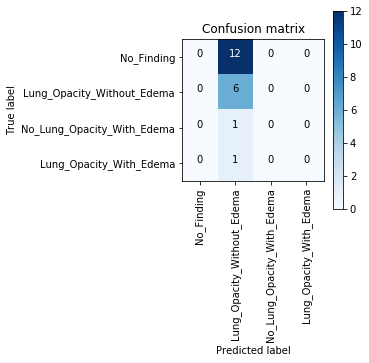

In [18]:
runCNNconfusion(X_train, Y_trainHot, X_test, Y_testHot,class_weight,4,6,1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

D:\Projects\An3\envs\naveen\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Projects\An3\envs\naveen\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Projects\An3\envs\naveen\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



                            precision    recall  f1-score   support

                No_Finding       0.64      0.58      0.61        12
Lung_Opacity_Without_Edema       0.22      0.33      0.27         6
No_Lung_Opacity_With_Edema       0.00      0.00      0.00         1
   Lung_Opacity_With_Edema       0.00      0.00      0.00         1

                 micro avg       0.45      0.45      0.45        20
                 macro avg       0.21      0.23      0.22        20
              weighted avg       0.45      0.45      0.45        20



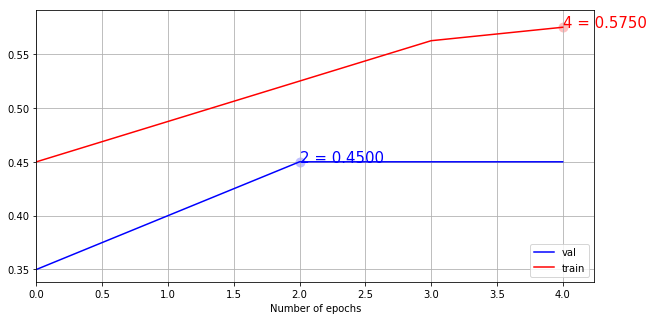

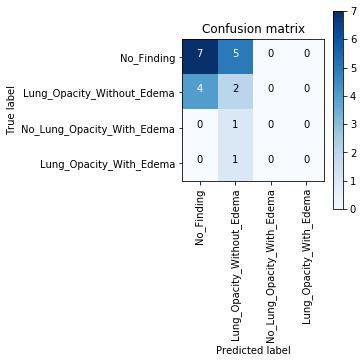

In [23]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
im_size = 128
map_characters=dict_characters
def vgg16network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model = VGG16(weights='imagenet',
        include_top=False, input_shape=(im_size, im_size, 3))
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
vgg16network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,4,5)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 221, 221, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 227, 227, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 111, 111, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 111, 111, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

Train on 720 samples, validate on 180 samples
Epoch 1/5
720/720 [==============================] - 1011s 1s/step - loss: 1.8860 - acc: 0.4500 - val_loss: 1.7147 - val_acc: 0.4222
Epoch 2/5
720/720 [==============================] - 1034s 1s/step - loss: 0.8750 - acc: 0.6764 - val_loss: 1.8546 - val_acc: 0.4611
Epoch 3/5
720/720 [==============================] - 1043s 1s/step - loss: 0.4722 - acc: 0.8250 - val_loss: 1.6804 - val_acc: 0.4556
Epoch 4/5
720/720 [==============================] - 970s 1s/step - loss: 0.2700 - acc: 0.9250 - val_loss: 1.5003 - val_acc: 0.4444
Epoch 5/5
720/720 [==============================] - 972s 1s/step - loss: 0.1712 - acc: 0.9667 - val_loss: 1.7294 - val_acc: 0.4278

Keras CNN #2 - accuracy: 0.4277777781089147 


                            precision    recall  f1-score   support

                No_Finding       0.51      0.78      0.62        83
Lung_Opacity_Without_Edema       0.22      0.14      0.17        56
No_Lung_Opacity_With_Edema       0.21 

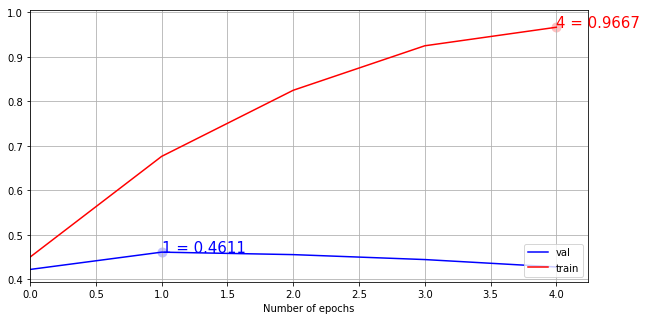

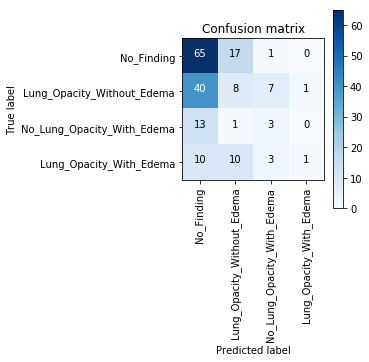

In [54]:
from keras.applications.densenet import DenseNet121
from keras.models import Model
weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
im_size = 221
map_characters=dict_characters
def DenseNet121network(a,b,c,d,e,f,g):
    num_class = f
    epochs = g
    base_model = DenseNet121(weights='imagenet',
        include_top=False, input_shape=(im_size, im_size, 3))
    # Add a new top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_class, activation='softmax')(x)
    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # First: train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0001), 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    model.fit(a,b, epochs=epochs, class_weight=e, validation_data=(c,d), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #2 - accuracy:', score[1], '\n')
    y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(d,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
    plt.show()
    return model
DenseNet121network(X_train, Y_trainHot, X_test, Y_testHot,class_weight,4,5)